In [25]:
import ee
import geemap
import xarray as xr

In [26]:
!pip install xee
import xee

In [27]:
ee.Authenticate()
ee.Initialize(project = 'ee-ahtshamm214', opt_url = 'https://earthengine-highvolume.googleapis.com')

In [38]:
map = geemap.Map(basemap = 'HYBRID')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [39]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          73.416108,
                          34.295799
                        ],
                        [
                          73.416108,
                          34.433248
                        ],
                        [
                          73.630259,
                          34.433248
                        ],
                        [
                          73.630259,
                          34.295799
                        ],
                        [
                          73.416108,
                          34.295799
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [40]:
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").merge(ee.ImageCollection("LANDSAT/LC09/C02/T1_L2"))\
.filterDate('2024','2026').filterBounds(roi).filter(ee.Filter.lt('CLOUD_COVER', 10)).sort('system:time_start')
landsat

In [41]:
def ndvi(img):
  band = img.select('SR.*').multiply(2.75e-05).add(-0.2)
  index = band.normalizedDifference(['SR_B5','SR_B4']).rename('ndvi')
  return index.copyProperties(img, ['system:time_start'])

landsat_ndvi = landsat.map(ndvi)
landsat_ndvi


In [42]:
ndvi_before = landsat_ndvi.filterDate('2024','2025').median().rename('ndvi_before')
ndvi_after = landsat_ndvi.filterDate('2025','2026').median().rename('ndvi_after')
ndvi_change = ndvi_before.subtract(ndvi_after).rename('ndvi_change')
ndvi_stack = ee.Image.cat([ndvi_before, ndvi_after, ndvi_change])
ndvi_stack

In [43]:
segmentation = ee.Algorithms.Image.Segmentation.SNIC(ndvi_stack).select('.*mean')
segmentation

In [44]:
def burned_area(img):
  img_thr = img.gt(0.3).selfMask()
  thr_pix = img_thr.multiply(ee.Image.pixelArea().divide(1e6))
  return thr_pix

forest_lost = burned_area(segmentation.select('ndvi_change_mean'))

forest_lost.reduceRegion(reducer = ee.Reducer.sum(), geometry = roi, scale = 30).values().get(0)

In [45]:
ds  = xr.open_dataset(segmentation, engine = 'ee', crs = 'EPSG:4326', geometry = roi, scale = 0.0003)
ds

<xarray.Dataset> Size: 4MB
Dimensions:           (time: 1, lon: 714, lat: 458)
Coordinates:
  * time              (time) int64 8B 0
  * lon               (lon) float64 6kB 73.42 73.42 73.42 ... 73.63 73.63 73.63
  * lat               (lat) float64 4kB 34.3 34.3 34.3 ... 34.43 34.43 34.43
Data variables:
    ndvi_before_mean  (time, lon, lat) float32 1MB ...
    ndvi_after_mean   (time, lon, lat) float32 1MB ...
    ndvi_change_mean  (time, lon, lat) float32 1MB ...
Attributes:
    crs:      EPSG:4326

In [47]:
import matplotlib.pyplot as plt

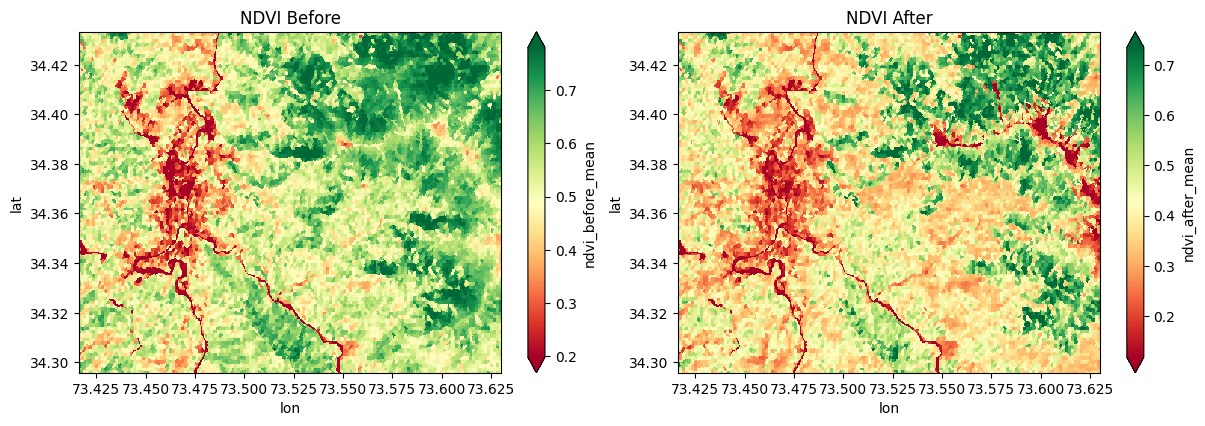

In [54]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
plt.tight_layout(w_pad = 2)

ds.ndvi_before_mean.plot(ax = ax[0], x = 'lon', y = 'lat', robust = True, cmap = 'RdYlGn')
ds.ndvi_after_mean.plot(ax = ax[1], x = 'lon', y = 'lat', robust = True, cmap = 'RdYlGn')
ax[0].set_title('NDVI Before')
ax[1].set_title('NDVI After')
plt.savefig('ndvi_change.png', dpi = 360, bbox_inches = 'tight')

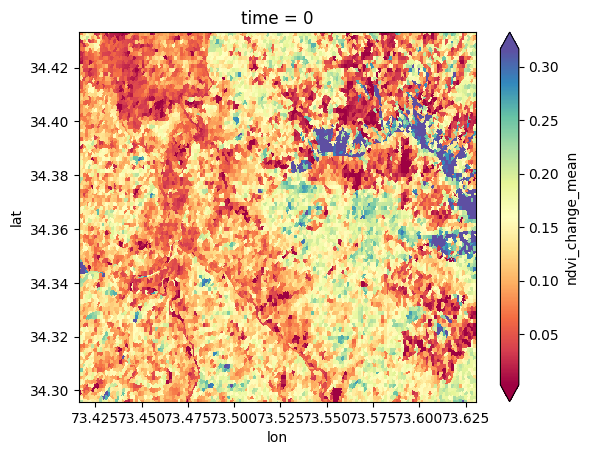

In [55]:
ds.ndvi_change_mean.plot(x = 'lon', y = 'lat', cmap = 'Spectral', robust = True)

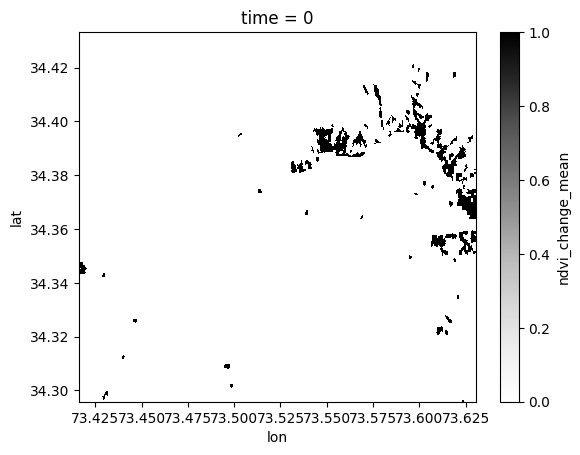

In [56]:
thr = ds.ndvi_change_mean > 0.3
thr.plot(x = 'lon', y = 'lat', cmap = 'Greys')